In [5]:
import os
import numpy as np
from python_speech_features import mfcc
from scipy.io import wavfile
import matplotlib.pyplot as plt
from hmmlearn import hmm as hmmLearn
import random
from scipy.stats import multivariate_normal
from tabulate import tabulate
from sklearn.metrics import confusion_matrix as cm

In [6]:
directories = ['metal', 'pop','blues', 'hiphop']
mfccsList = {}

for name in directories:
    generList = []
    directoryPath = os.path.join(name)
    for fileName in os.listdir(directoryPath)[:100]:
        audioFilePath = os.path.join(directoryPath, fileName)
        freq, audio = wavfile.read(audioFilePath)
        audioFeatures = mfcc(audio, freq, nfft=1024)
        generList.append(audioFeatures)
    mfccsList[name] = generList

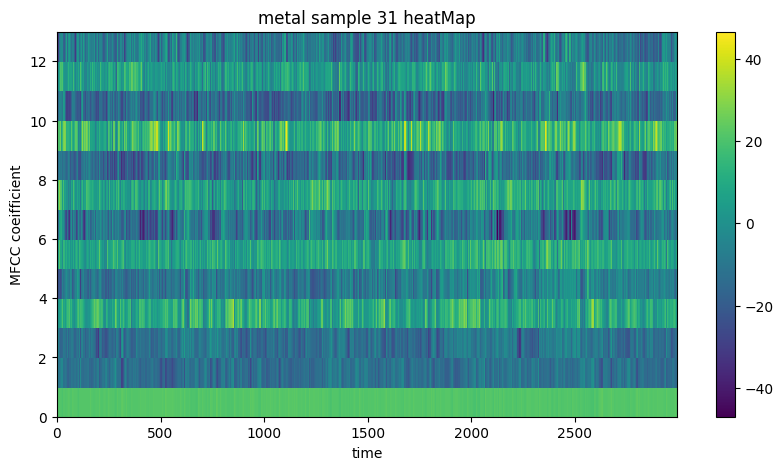

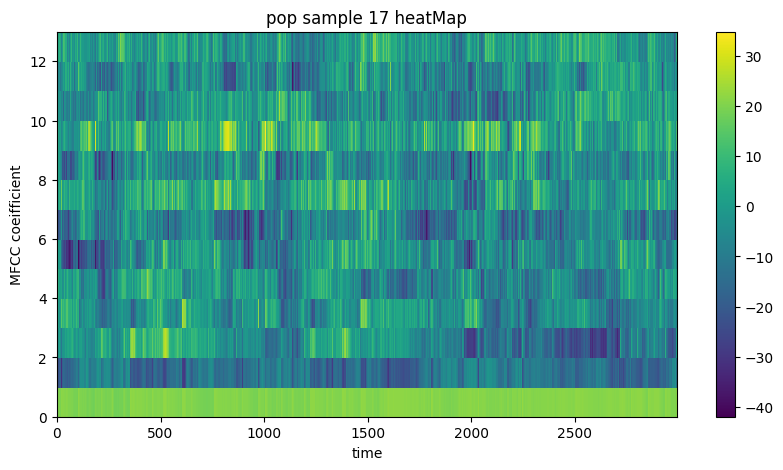

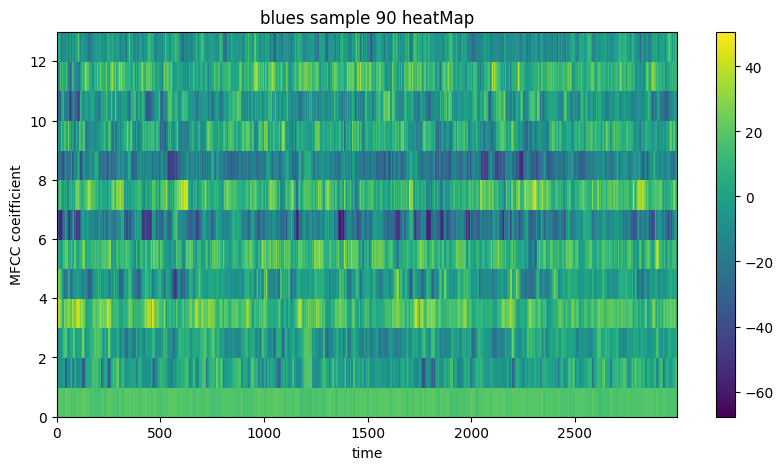

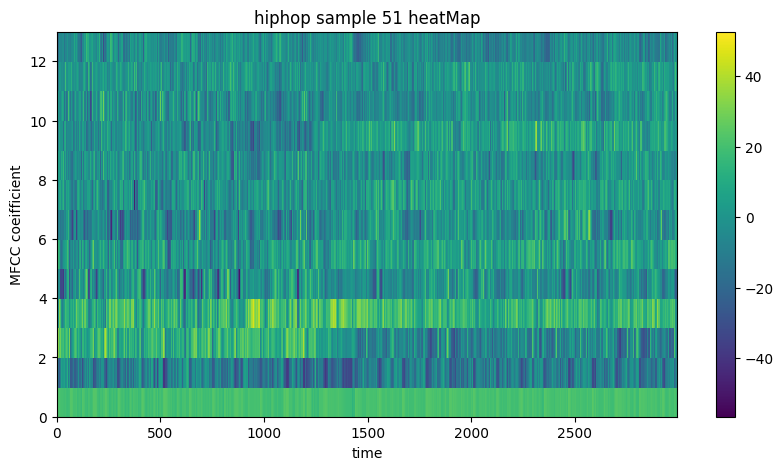

In [7]:
for genre in directories:
    index = random.randint(0,99)
    mfcc = mfccsList[genre][index]
    plt.figure(figsize=[10,5])
    plt.pcolor(mfcc.T)
    plt.title(genre + " sample " + str(index) + " heatMap")
    plt.xlabel("time")
    plt.ylabel("MFCC coeifficient")
    plt.colorbar()
    plt.show()

In [8]:
maxFrame = mfccsList['metal'][0].shape[0]
for name in directories:
    for i in range(len(mfccsList[name])):
        maxFrame = min(maxFrame,mfccsList[name][i].shape[0])

print(maxFrame)

2985


In [9]:
testSampels = {}
trainSampels = {}

for name in directories: 
    lenth = len(mfccsList[name])
    trainList = []
    testList = []
    for i in range(lenth):
        sample = mfccsList[name][i][:maxFrame,:]
        if (i < 80):
            trainList.append(sample)
        else:
            testList.append(sample)
    testSampels[name] = np.array(testList)
    trainSampels[name] = np.array(trainList)

In [10]:
trainData = {}

for name in directories:
    trainData[name] = trainSampels[name].reshape(-1,13)

testSampelsList = np.vstack([ testSampels['metal'], testSampels['pop'],testSampels['blues'], testSampels['hiphop']])


In [11]:
HMMs = {}
for name in directories:
    h =  hmmLearn.GaussianHMM(n_components=5, n_iter=11)
    h.fit(trainData[name])
    HMMs[name] = h

In [12]:
labelsHmmLearn = []
for i in range(80): 
    maxScore = max(HMMs["metal"].score(testSampelsList[i]),HMMs["pop"].score(testSampelsList[i]),HMMs["blues"].score(testSampelsList[i]), HMMs["hiphop"].score(testSampelsList[i]))
   
    if (maxScore == HMMs["metal"].score(testSampelsList[i])):
        labelsHmmLearn.append(0)
    elif (maxScore == HMMs["pop"].score(testSampelsList[i])):
        labelsHmmLearn.append(1)
    elif (maxScore == HMMs["blues"].score(testSampelsList[i])):
        labelsHmmLearn.append(2)
    elif(maxScore == HMMs["hiphop"].score(testSampelsList[i])):
        labelsHmmLearn.append(3)



In [13]:
def PrintConfusion(labels):
    trueLabels = 20 * [0] + 20 * [1] + 20 * [2] + 20 * [3]
    matrix = cm(y_true=trueLabels, y_pred=labels)
    data = []
    for i in range(len(directories)):
        newRow =  [directories[i]]
        for j in range(len(directories)):
            newRow.append(matrix[i][j])
        data.append(newRow)
    print(tabulate(data, headers=["True/Predicted", directories[0], directories[1],directories[2],directories[3]]))
    return matrix


In [14]:
def PrintAccuracy(matrix):
    accuracyList = {}
    accuracyList["metal"] = (+ matrix[2][2] + matrix[2][3] + matrix[3][1] + matrix[3][2] + matrix[3][3] + matrix[0][0] + matrix[1][1] + matrix[1][2] + matrix[1][3] + matrix[2][1] )  / 80
    accuracyList["pop"] = (matrix[3][0] + matrix[2][2] + matrix[2][3] + matrix[3][2] + matrix[3][3]+matrix[1][1] + matrix[0][0] + matrix[0][2] + matrix[0][3] + matrix[2][0] ) / 80
    accuracyList["blues"] = (matrix[2][2] + matrix[0][0] + matrix[0][1] + matrix[1][0] + matrix[1][1] + matrix[0][3] + matrix[1][3] + matrix[3][0] + matrix[3][1] + matrix[3][3]) / 80
    accuracyList["hiphop"] = (matrix[3][3] + matrix[0][0] + matrix[0][1] + matrix[0][2] + matrix[1][0] + matrix[1][1] + matrix[1][2] + matrix[2][0] + matrix[2][1] + matrix[2][2]) / 80
    totalAccuracy = (matrix[0][0] + matrix[1][1] + matrix[2][2] + matrix[3][3]) / 80


    dataAccuracy = [["metal",accuracyList["metal"]],["pop",accuracyList["pop"]],["blues",accuracyList["blues"]],["hiphop",accuracyList["hiphop"]],["total",totalAccuracy]]

    print(tabulate(dataAccuracy, headers=["","accuracy"]))
    return accuracyList




In [15]:
def PrintRecall(matrix):
    recallList = {}
    for i in range(len(directories)):
        recall = matrix[i][i]
        sumLine = 0
        for j in range(len(directories)):
            sumLine += matrix[i][j]
        recallList[directories[i]] = recall/sumLine 


    dataRecall = [["metal",recallList["metal"]],["pop",recallList["pop"]],["blues",recallList["blues"]],["hiphop",recallList["hiphop"]]]

    print(tabulate(dataRecall , headers=["","recall"]))
    return recallList





In [16]:
def PrintPrecision(matrix):
    precisionList = {}
    for i in range(len(directories)):
        precision = matrix[i][i]
        sumLine = 0
        for j in range(len(directories)):
            sumLine += matrix[j][i]
        if(sumLine == 0):
            precisionList[directories[i]] = 0
        else:
            precisionList[directories[i]] = precision/sumLine
 
    dataPrecision = [["metal",precisionList["metal"]],["pop",precisionList["pop"]],["blues",precisionList["blues"]],["hiphop",precisionList["hiphop"]]]
    print(tabulate(dataPrecision , headers=["","precision"]))
    return precisionList

In [17]:
def PrintF1(recallList,precisionList):
    def F1Score(recallList,precisionList):
        f1List = {}
        for name in directories:
            f1List[name] = (2 * recallList[name] * precisionList[name]) / (recallList[name] + precisionList[name])
        return f1List

    f1List = F1Score(recallList,precisionList)

    dataF1 = [["metal",f1List["metal"]],["pop",f1List["pop"]],["blues",f1List["blues"]],["hiphop",f1List["hiphop"]]]

    print(tabulate(dataF1 , headers=["","f1"]))
    return f1List



In [18]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                ## TODO: Forward algorithm for the first time step
                alpha[:, t] = self.initial_prob.flatten() * observation_matrix[:, t]
                
            else:
                alpha[:, t] = np.dot(alpha[:, t-1] * self.transition_matrix.T, observation_matrix[:, t])
                ## TODO: Forward algorithm for the next time steps

            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            #beta[:, t] = ## TODO: Backward algorithm for the time steps of the HMM
            beta[:, t] = np.dot(self.transition_matrix, (observation_matrix[:, t+1] * beta[:, t+1]))
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            #B[s, :] = ## TODO: Compute the likelihood of observations with multivariate normal pdf
            B[s, :] = multivariate_normal.pdf(obs.T,mean=self.mean[:,s], cov=self.covariances[:,:,s])

        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]

       
        B = self._state_likelihood(obs)
        #B = ## TODO

        #log_likelihood, alpha = ## TODO
        log_likelihood, alpha = self._forward(B)
        #beta = ## TODO
        beta = self._backward(B)
        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))
        for t in range(T - 1):
            #partial_sum = ## TODO
            partial_sum = np.dot(alpha[:, t] * beta[:, t+1].T , self.transition_matrix * B[:, t+1])
            xi_sum += self._normalize(partial_sum)
            #partial_g = ## TODO
            partial_g = alpha[:, t] * beta[:, t]
            gamma[:, t] = self._normalize(partial_g)
        #partial_g = ## TODO

        partial_g = alpha[:,-1] * beta[:,-1]
        gamma[:, -1] = self._normalize(partial_g)
        #expected_prior = ## TODO
        expected_prior = gamma[:, 0]
        expected_transition = self._stochasticize(xi_sum)
        

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=1):
        obs = self._normalize(obs)
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        obs = self._normalize(obs)
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood



In [19]:

HMMsScratch = {}
for name in directories:
    h =  HMM(5)
    h.train(trainData[name].T,4)
    HMMsScratch[name] = h


In [20]:
labelsHMM = []
for i in range(80): 
    maxScore = max(HMMsScratch["metal"].score(testSampelsList[i].T),HMMsScratch["pop"].score(testSampelsList[i].T),HMMsScratch["blues"].score(testSampelsList[i].T), HMMsScratch["hiphop"].score(testSampelsList[i].T))
   
    if (maxScore == HMMsScratch["metal"].score(testSampelsList[i].T)):
        labelsHMM.append(0)
    elif (maxScore == HMMsScratch["pop"].score(testSampelsList[i].T)):
        labelsHMM.append(1)
    elif (maxScore == HMMsScratch["blues"].score(testSampelsList[i].T)):
        labelsHMM.append(2)
    elif(maxScore == HMMsScratch["hiphop"].score(testSampelsList[i].T)):
        labelsHMM.append(3)



In [21]:
print("\nLibrary Confusion Matrix\n")
matrixLibrary = PrintConfusion(labelsHmmLearn)
print("\nScratch Confusion Matrix\n")
matrixScratch = PrintConfusion(labelsHMM)


Library Confusion Matrix

True/Predicted      metal    pop    blues    hiphop
----------------  -------  -----  -------  --------
metal                  15      0        5         0
pop                     0     20        0         0
blues                   2      0       17         1
hiphop                  1      1        4        14

Scratch Confusion Matrix

True/Predicted      metal    pop    blues    hiphop
----------------  -------  -----  -------  --------
metal                  10      0        0        10
pop                     1     13        0         6
blues                   8      0        0        12
hiphop                  6      0        0        14


In [22]:
print("\nLibrary Accuracy\n")
accuracyLibrary = PrintAccuracy(matrixLibrary)
print("\nScratch Accuracy\n")
accuracyScratch = PrintAccuracy(matrixScratch)


Library Accuracy

          accuracy
------  ----------
metal       0.9
pop         0.9875
blues       0.85
hiphop      0.9125
total       0.825

Scratch Accuracy

          accuracy
------  ----------
metal       0.6875
pop         0.9125
blues       0.75
hiphop      0.575
total       0.4625


In [23]:
print("\nLibrary Recall\n")
recallLibrary = PrintRecall(matrixLibrary)
print("\nScratch Recall\n")
recallScratch = PrintRecall(matrixScratch)


Library Recall

          recall
------  --------
metal       0.75
pop         1
blues       0.85
hiphop      0.7

Scratch Recall

          recall
------  --------
metal       0.5
pop         0.65
blues       0
hiphop      0.7


In [24]:
print("\nLibrary Precision\n")
precisionLibrary = PrintPrecision(matrixLibrary)
print("\nScratch Precision\n")
precisionScratch = PrintPrecision(matrixScratch)


Library Precision

          precision
------  -----------
metal      0.833333
pop        0.952381
blues      0.653846
hiphop     0.933333

Scratch Precision

          precision
------  -----------
metal      0.4
pop        1
blues      0
hiphop     0.333333


In [25]:
print("\nLibrary F1\n")
f1Library = PrintF1(recallLibrary,precisionLibrary)
print("\nScratch F1\n")
f1Scratch = PrintF1(recallScratch,precisionScratch)


Library F1

              f1
------  --------
metal   0.789474
pop     0.97561
blues   0.73913
hiphop  0.8

Scratch F1

                f1
------  ----------
metal     0.444444
pop       0.787879
blues   nan
hiphop    0.451613


C:\Users\Hesam\AppData\Local\Temp\ipykernel_21760\1398646448.py:5: RuntimeWarning: invalid value encountered in double_scalars
  f1List[name] = (2 * recallList[name] * precisionList[name]) / (recallList[name] + precisionList[name])


In [26]:
def Macro(f1List,precisionList,recallList):
    def MacroCalc(list):
        macro = 0
        for name in directories:
            macro += list[name]
        return macro/len(list)
    print("Macro Precision : " , MacroCalc(precisionList))
    print("Macro Recall : " , MacroCalc(recallList))
    print("Macro F1 : " , MacroCalc(f1List))
    


In [27]:
def Weighted(f1List,precisionList,recallList):
    def WeightedCalc(list):
        weighted = 0
        for name in directories:
            weighted += list[name] * 20
        return weighted/(len(list) * 20)
    print("Weighted Precision : " , WeightedCalc(precisionList))
    print("Weighted Recall : " , WeightedCalc(recallList))
    print("Weighted F1 : " , WeightedCalc(f1List))

In [28]:
def Micro(matrix):
    micro =(matrix[0][0] + matrix[1][1] + matrix[2][2] + matrix[3][3]) / 80  
    print("Micro Precision : ", micro)
    print("Micro Recall : ", micro)
    print("Micro F1 : ", micro)
    print("Micro Accuracy : ", micro)
    
    

In [29]:
print("\nLibrary Macro\n")
Macro(f1Library,precisionLibrary,recallLibrary)
print("\nScratch Macro\n")
Macro(f1Scratch,precisionScratch,recallScratch)




Library Macro

Macro Precision :  0.8432234432234431
Macro Recall :  0.825
Macro F1 :  0.8260534687726739

Scratch Macro

Macro Precision :  0.4333333333333333
Macro Recall :  0.46249999999999997
Macro F1 :  nan


In [30]:
print("\nLibrary Weighted\n")
Weighted(f1Library,precisionLibrary,recallLibrary)
print("\nScratch Weighted\n")
Weighted(f1Scratch,precisionScratch,recallScratch)



Library Weighted

Weighted Precision :  0.8432234432234432
Weighted Recall :  0.825
Weighted F1 :  0.8260534687726739

Scratch Weighted

Weighted Precision :  0.4333333333333333
Weighted Recall :  0.4625
Weighted F1 :  nan


In [31]:
print("\nLibrary Micro\n")
Micro(matrixLibrary)
print("\nScratch Micro\n")
Micro(matrixScratch)



Library Micro

Micro Precision :  0.825
Micro Recall :  0.825
Micro F1 :  0.825
Micro Accuracy :  0.825

Scratch Micro

Micro Precision :  0.4625
Micro Recall :  0.4625
Micro F1 :  0.4625
Micro Accuracy :  0.4625
